# Project Four: Part Two

### Import Packages

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import xlrd
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from sklearn.metrics import r2_score
from pmdarima.arima import ndiffs
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot
import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
from statsmodels.tsa.stattools import adfuller


### ACF PACF Function

In [10]:
# acf and pacf function

def plot_acf_pacf(ts, figsize=(10,8), lags = 24, zipcode = 'add'):
    
    fig,ax = plt.subplots(nrows=3,
                         figsize = figsize)
    
    #plot time series
    ts.plot(ax=ax[0])
    
    #plot acf, pacf
    plot_acf(ts,ax=ax[1], lags=lags)
    plot_pacf(ts, ax=ax[2], lags=lags)
    fig.tight_layout()
    
    fig.suptitle(f'Zipcode: {zipcode}',y=1.1, fontsize=20)
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(min_n_ticks=lags, integer = True))
        a.xaxis.grid()
    return fig,ax

### Open Pickled Dataframe

In [11]:
kings_grouped = pd.read_pickle("./kings_grouped.pkl")

### 11221

In [12]:
two_two_one = kings_grouped.loc[11221]

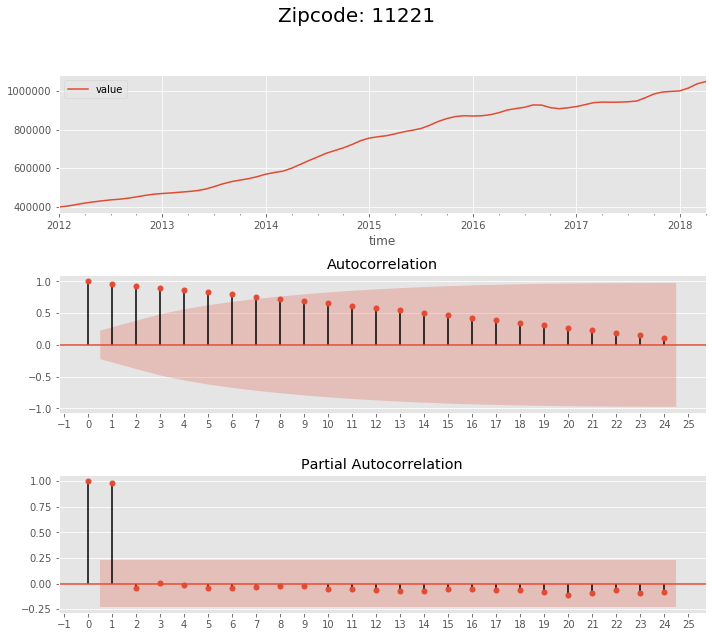

In [13]:
plot_acf_pacf(two_two_one, zipcode = '11221')
plt.show()

### Decompose Time Series

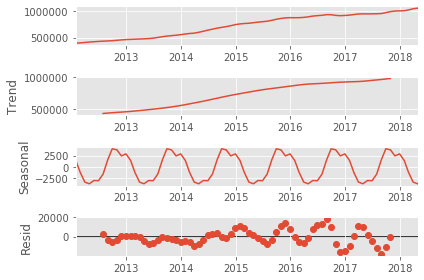

In [15]:
decompose_result = seasonal_decompose(two_two_one, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

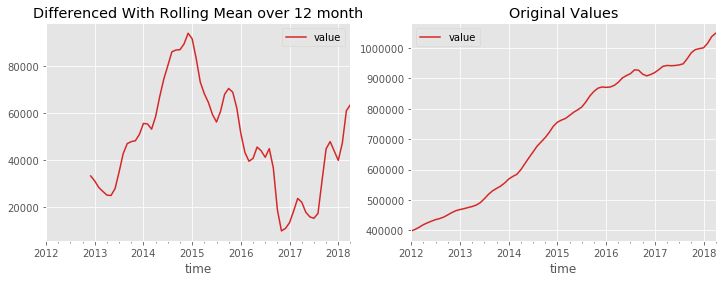

In [16]:
rolling_mean = two_two_one.rolling(window = 12).mean()
two_two_one_rolled_detrended = two_two_one - rolling_mean

ax1 = plt.subplot(121)
two_two_one_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_two_one.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [17]:
dftest = adfuller(two_two_one_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.518817841723839
2. P-Value :  0.1109626163105864
3. Num Of Lags :  8
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 56
5. Critical Values :
	 1% :  -3.552928203580539
	 5% :  -2.9147306250000002
	 10% :  -2.595137155612245


### Using Differencing with Mean Rolled Time Series for Seasonality

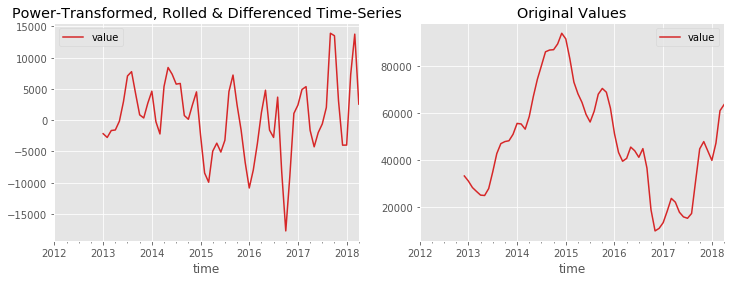

In [18]:
two_two_one_rolled_detrended_diff = two_two_one_rolled_detrended - two_two_one_rolled_detrended.shift()

ax1 = plt.subplot(121)
two_two_one_rolled_detrended_diff.plot(figsize=(8,4), color="tab:red", title="Power-Transformed, Rolled & Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
two_two_one_rolled_detrended.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

In [19]:
two_two_one = two_two_one_rolled_detrended_diff

### Retesting with the Dicky-Fuller Test

Technically does not have stationarity.

In [20]:
dftest = adfuller(two_two_one.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.6600508722281657
2. P-Value :  0.0812099696525827
3. Num Of Lags :  4
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 59
5. Critical Values :
	 1% :  -3.5463945337644063
	 5% :  -2.911939409384601
	 10% :  -2.5936515282964665


### Differencing

Autocorrelation is positive, so most likely a differencing of one will be best. 

In [21]:
two_two_one_diff = two_two_one.diff().dropna()
two_two_one_diff.head()

,value
time,
2013-02-28,-600.000000
2013-03-31,1108.333333
2013-04-30,83.333333
2013-05-31,1408.333333
2013-06-30,3100.000000


### ACF & PACF with Differenced Dataframe

These can be used to better understand the AR & MA components.

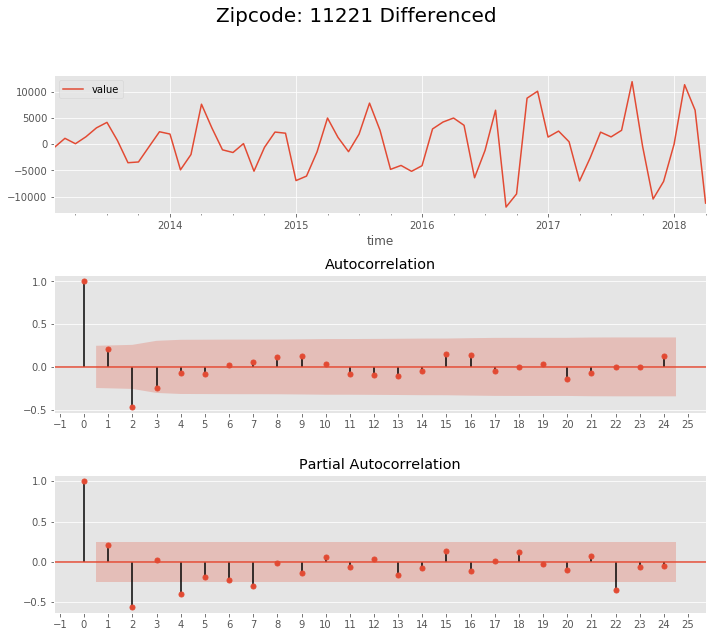

In [22]:
plot_acf_pacf(two_two_one_diff, zipcode = '11221 Differenced')
plt.show()

### Parameter Selection

In [23]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [24]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_two_one, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [25]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 1, 1)
pdqs    (0, 1, 1, 12)
aic           979.049
Name: 27, dtype: object

### Fitting the Time Series Model - ARIMA

In [26]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_two_one, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1079      0.597     -0.181      0.857      -1.277       1.061
ma.L1          0.7297      0.357      2.042      0.041       0.029       1.430
ar.S.L12      -0.0373      0.362     -0.103      0.918      -0.747       0.672
ma.S.L12      -1.0177      0.257     -3.957      0.000      -1.522      -0.514
sigma2        5.3e+07   1.19e-08   4.44e+15      0.000     5.3e+07     5.3e+07


### Plot Diagnostics


1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

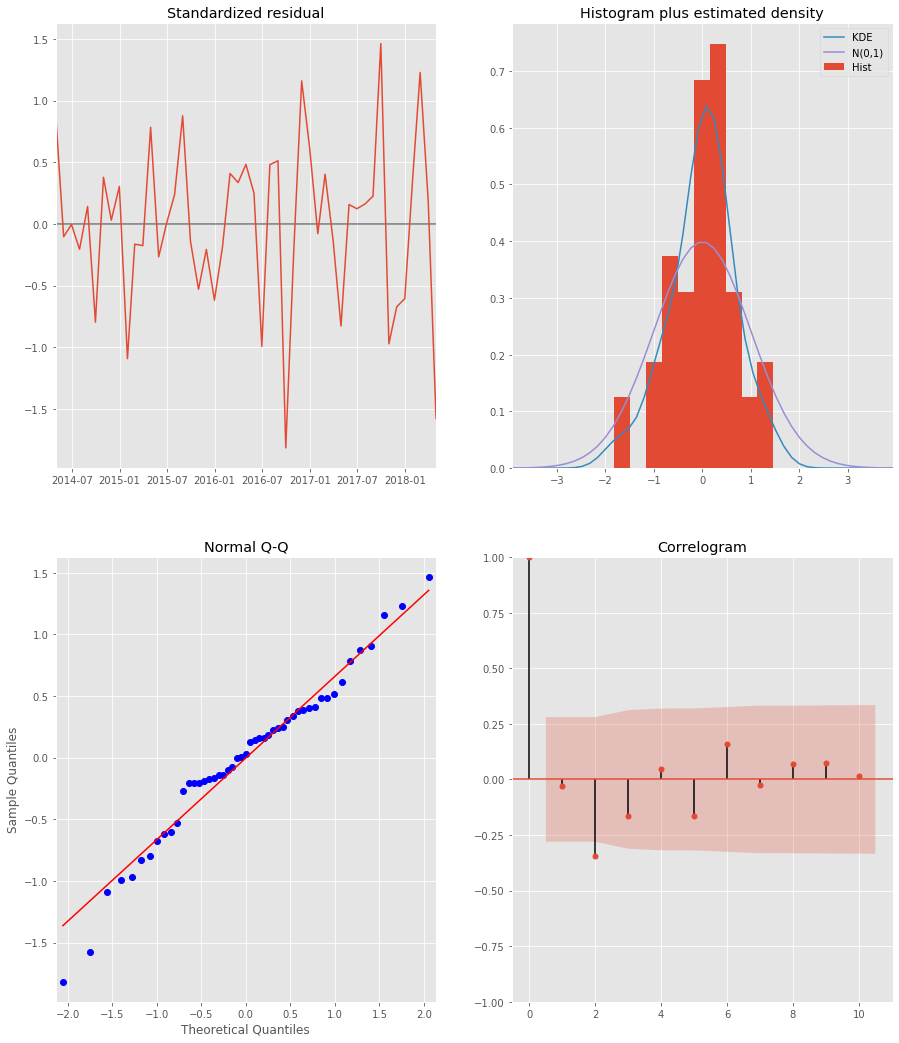

In [27]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [28]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

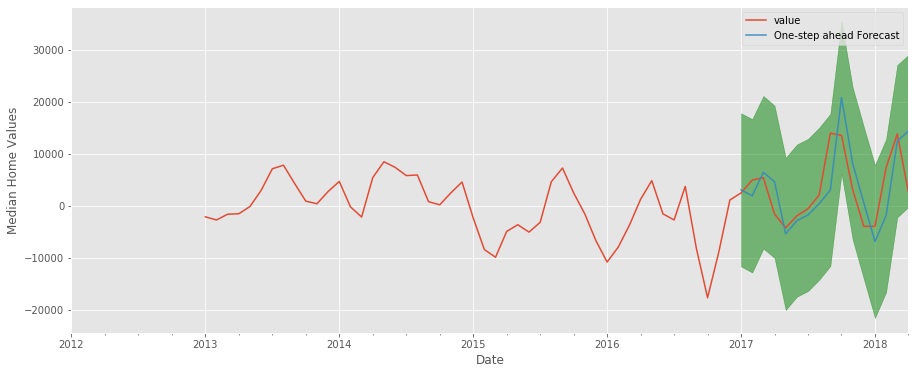

In [29]:

rcParams['figure.figsize'] = 15, 6

ax = two_two_one['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [30]:
val_forecasted = pred.predicted_mean
val_truth = two_two_one.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 31678098.76


### Model Validation - Dynamic Forecasting

In [31]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

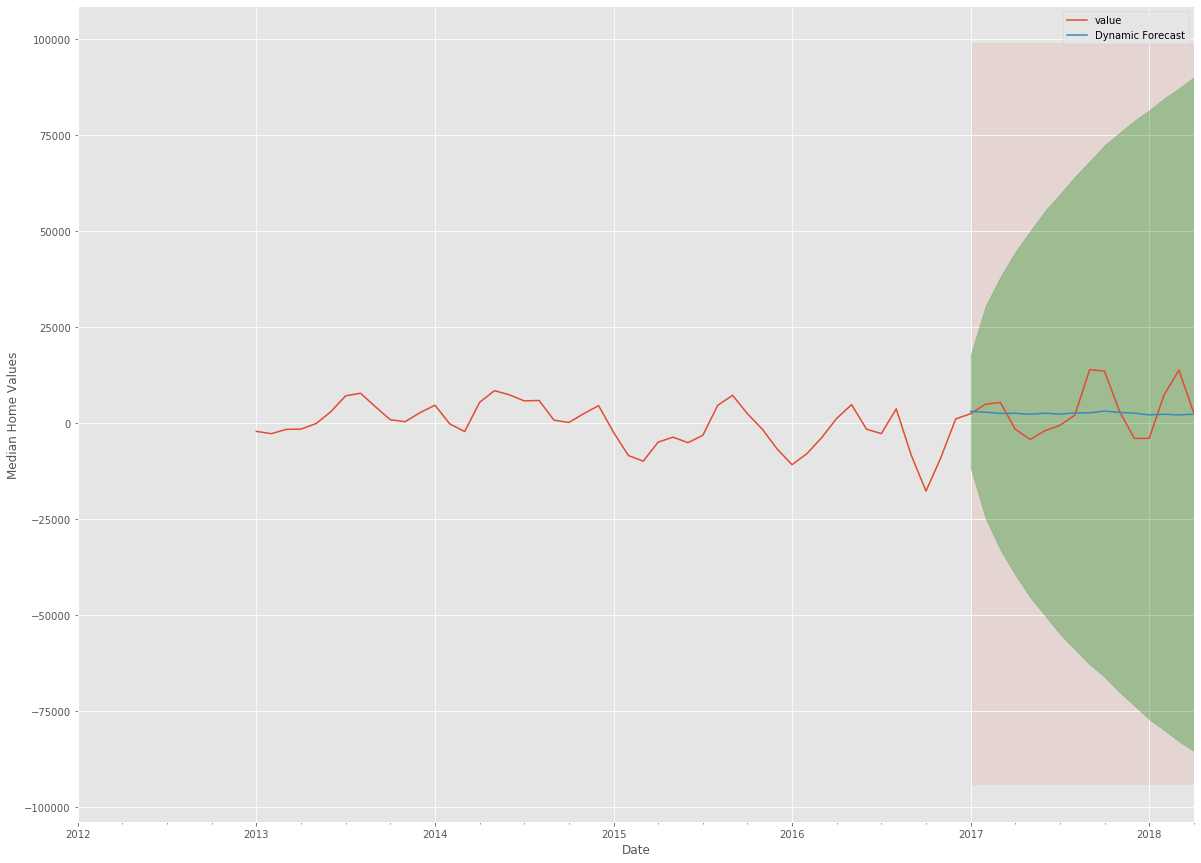

In [32]:
ax = two_two_one['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [33]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_two_one.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 36235330.49


### Visualizing Confidence Interval

In [34]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

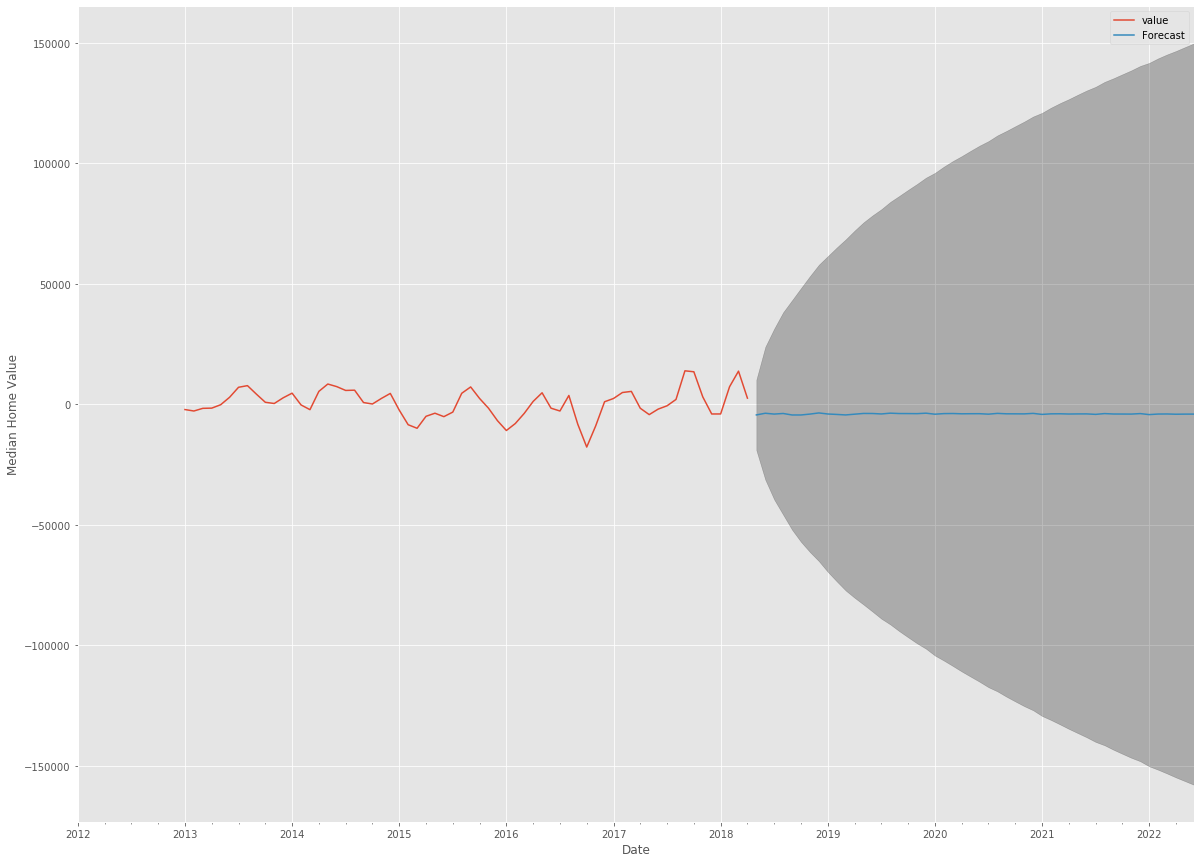

In [35]:
ax = two_two_one.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11221 Conclusion: 

### 11229

In [36]:
two_two_nine = kings_grouped.loc[11229]

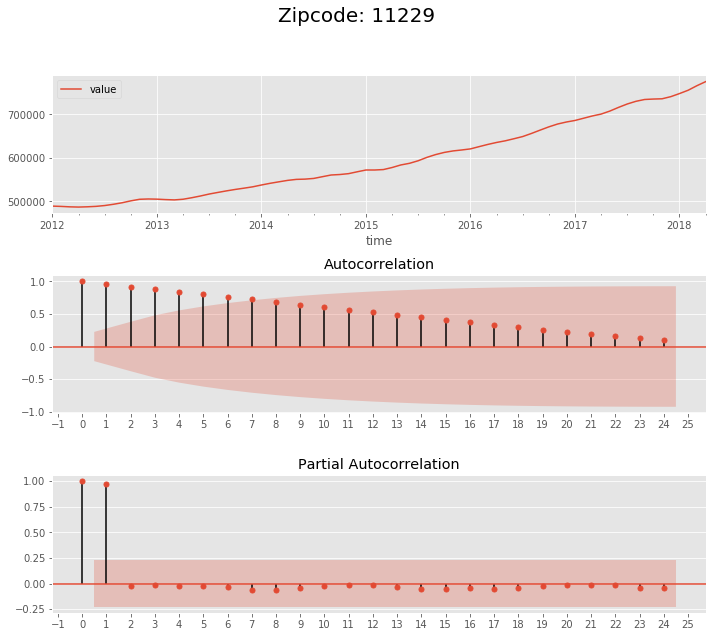

In [37]:
plot_acf_pacf(two_two_nine, zipcode = '11229')
plt.show()

### Decompose Time Series

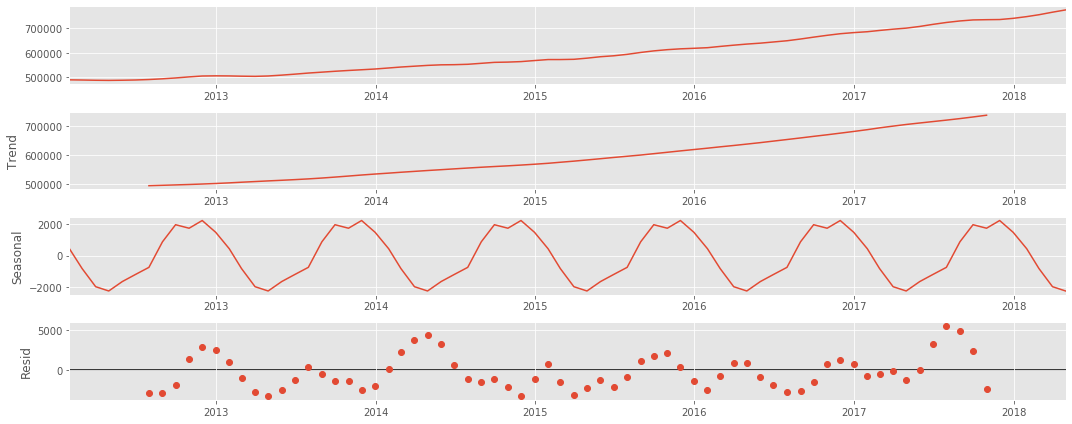

In [38]:
decompose_result = seasonal_decompose(two_two_nine, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

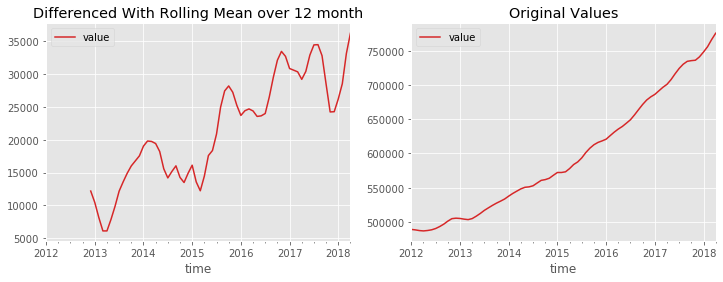

In [39]:
rolling_mean = two_two_nine.rolling(window = 12).mean()
two_two_nine_rolled_detrended = two_two_nine - rolling_mean

ax1 = plt.subplot(121)
two_two_nine_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_two_nine.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [40]:
dftest = adfuller(two_two_nine_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -0.7528872350350656
2. P-Value :  0.8325710479269115
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 54
5. Critical Values :
	 1% :  -3.55770911573439
	 5% :  -2.9167703434435808
	 10% :  -2.59622219478738


### Using Differencing with Mean Rolled Time Series for Seasonality

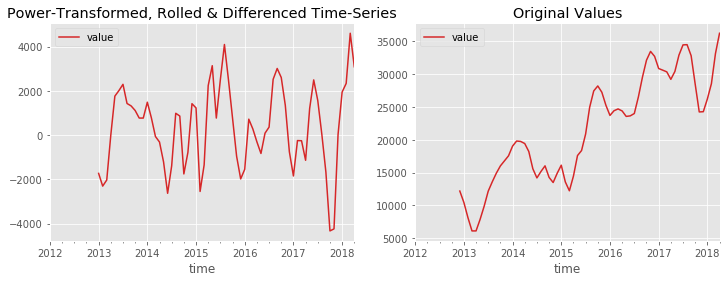

In [41]:
two_two_nine_rolled_detrended_diff = two_two_nine_rolled_detrended - two_two_nine_rolled_detrended.shift()

ax1 = plt.subplot(121)
two_two_nine_rolled_detrended_diff.plot(figsize=(8,4), color="tab:red", title="Power-Transformed, Rolled & Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
two_two_nine_rolled_detrended.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

In [42]:
two_two_nine = two_two_nine_rolled_detrended_diff

### Retesting with the Dicky-Fuller Test

Technically does not have stationarity.

In [43]:
dftest = adfuller(two_two_nine.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.515237588498182
2. P-Value :  0.007604276224172382
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 54
5. Critical Values :
	 1% :  -3.55770911573439
	 5% :  -2.9167703434435808
	 10% :  -2.59622219478738


### Parameter Selection

In [44]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [45]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_two_nine, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [46]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 1, 1)
pdqs    (0, 1, 1, 12)
aic           875.161
Name: 27, dtype: object

### Fitting the Time Series Model - ARIMA

COMMENTS ON THE P VALUES - LOW P VAL = GOOD 

In [47]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_two_nine, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2121      0.420     -0.505      0.613      -1.035       0.610
ma.L1          0.6241      0.324      1.924      0.054      -0.012       1.260
ma.S.L12      -1.0861      1.276     -0.851      0.395      -3.587       1.415
sigma2      2.223e+06   2.97e+06      0.748      0.454    -3.6e+06    8.04e+06


### Plot Diagnostics

COMMENTS ON PLOT: 
1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

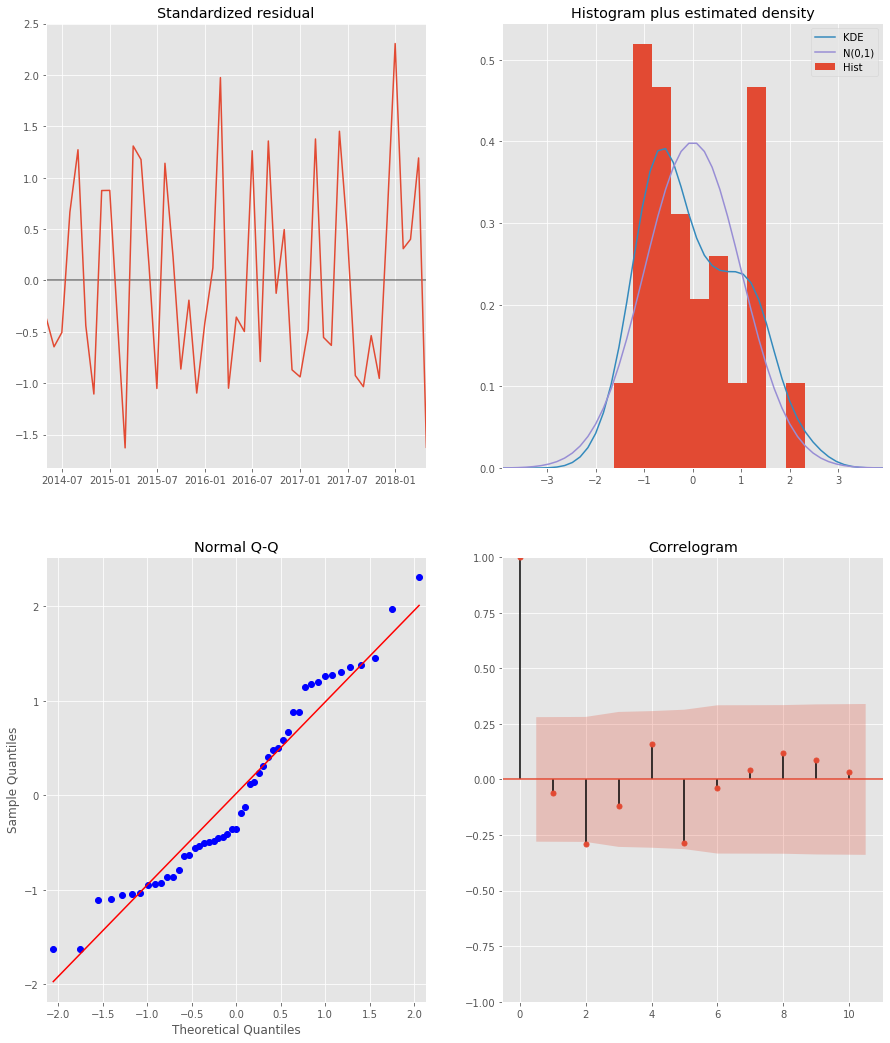

In [48]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [49]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

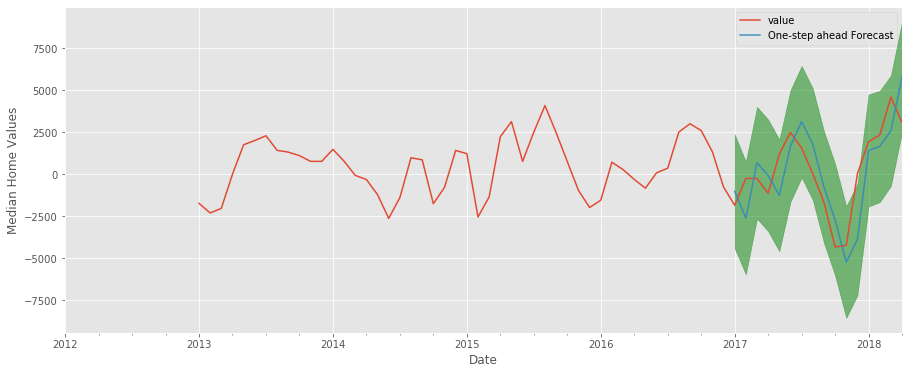

In [50]:

rcParams['figure.figsize'] = 15, 6

ax = two_two_nine['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [51]:
val_forecasted = pred.predicted_mean
val_truth = two_two_nine.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 3284837.57


### Model Validation - Dynamic Forecasting

In [52]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

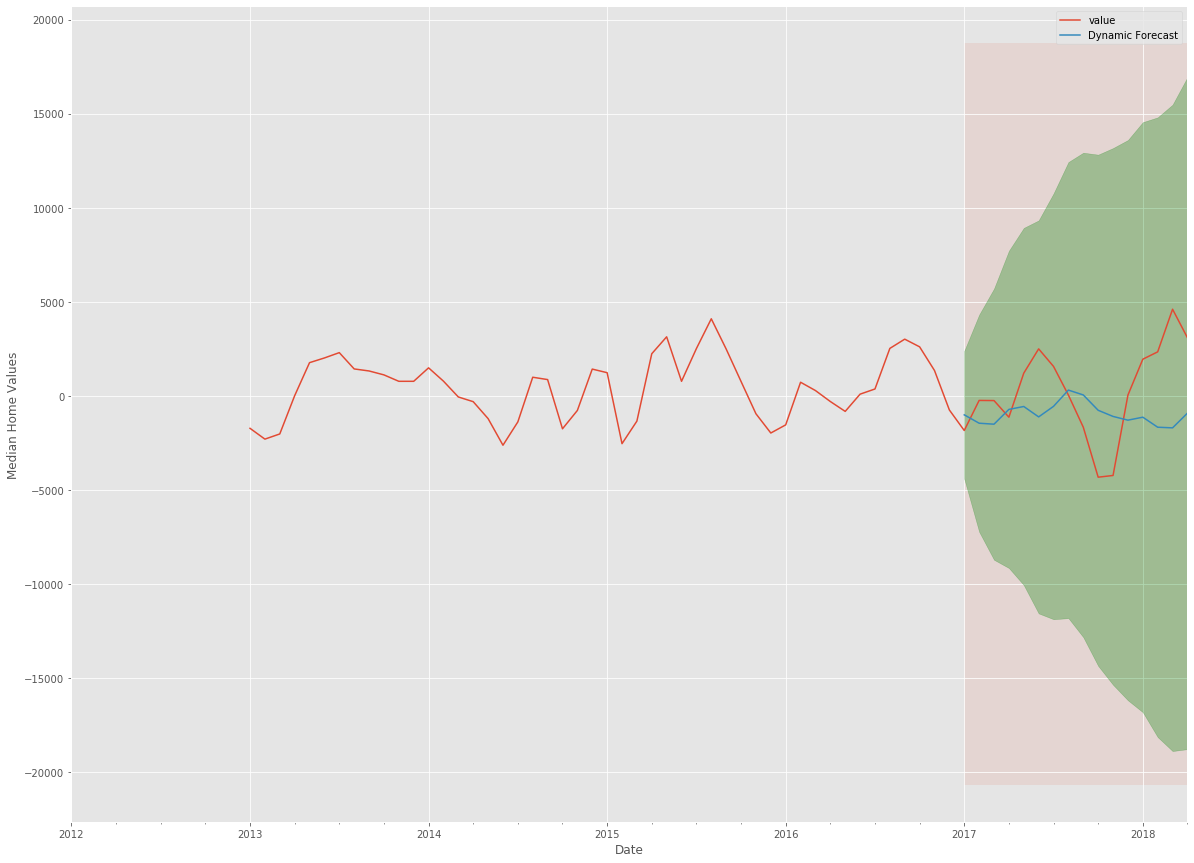

In [53]:
ax = two_two_nine['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [54]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_two_nine.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 8339710.7


### Visualizing Confidence Interval

In [55]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

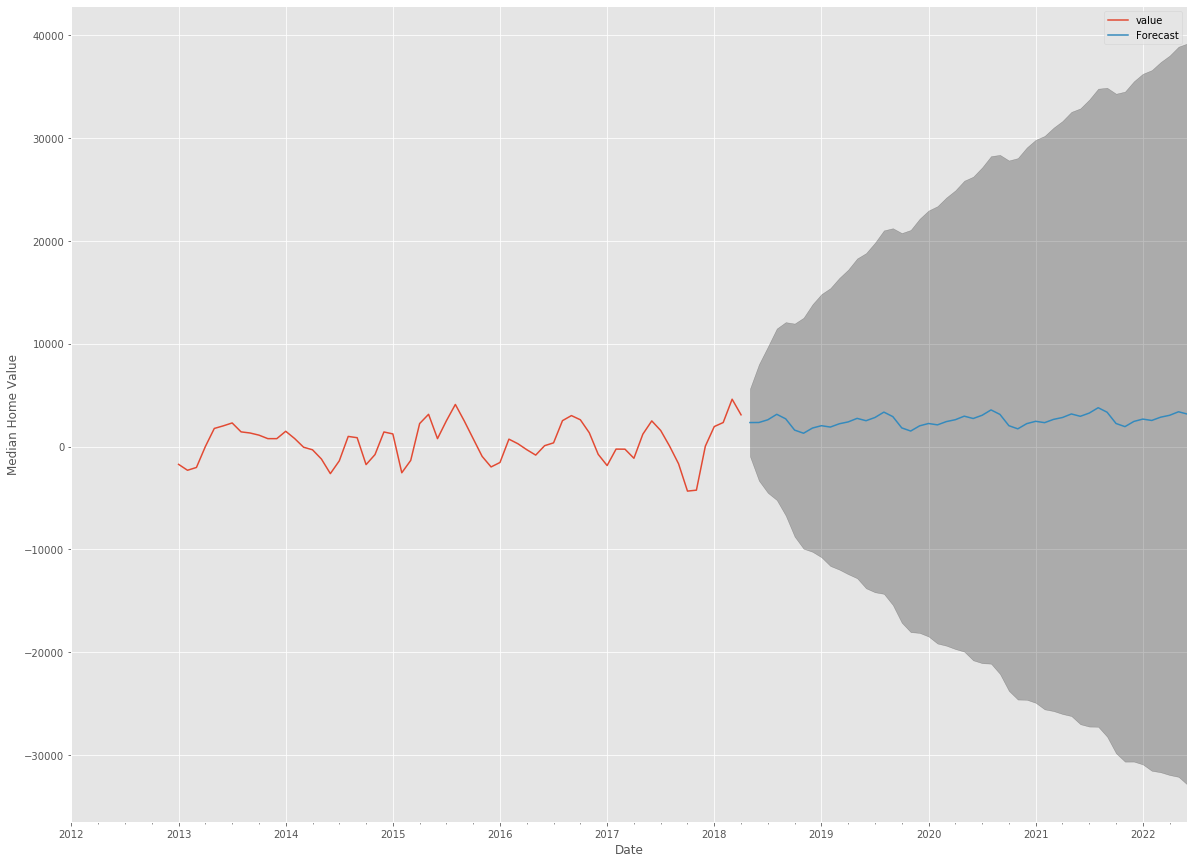

In [56]:
ax = two_two_nine.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11229 Conclusion: 

### 11234

In [74]:
two_three_four = kings_grouped.loc[11234]

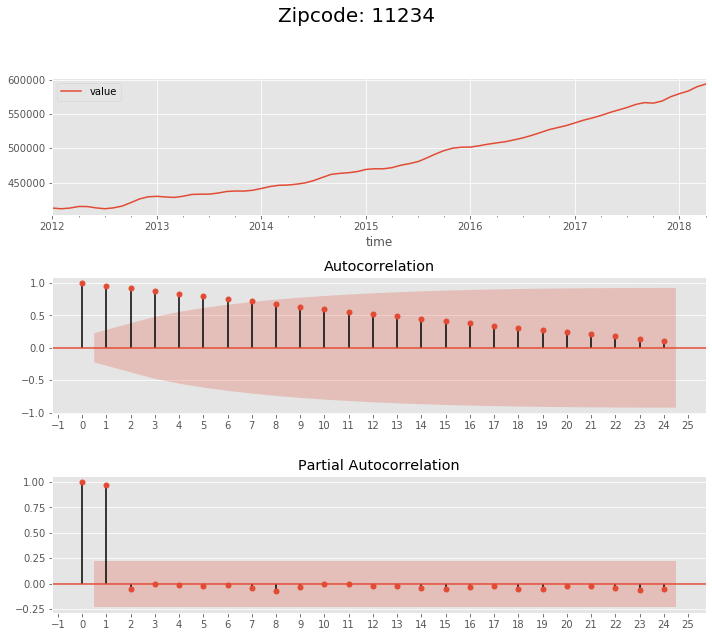

In [75]:
plot_acf_pacf(two_three_four, zipcode = '11234')
plt.show()

### Decompose Time Series

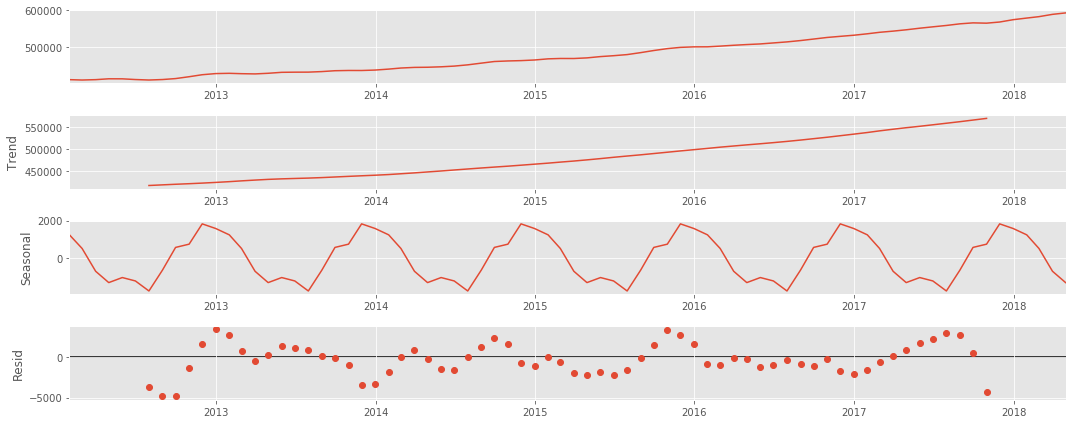

In [76]:
decompose_result = seasonal_decompose(two_three_four, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

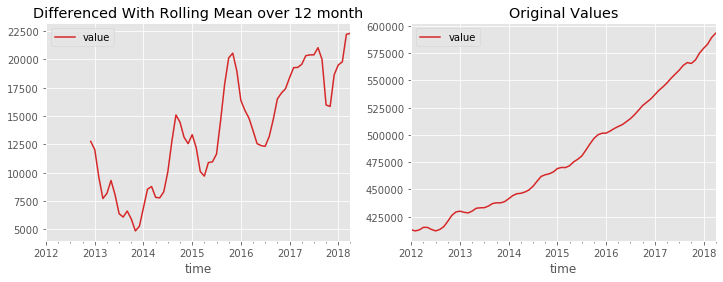

In [77]:
rolling_mean = two_three_four.rolling(window = 12).mean()
two_three_four_rolled_detrended = two_three_four - rolling_mean

ax1 = plt.subplot(121)
two_three_four_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_three_four.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [78]:
dftest = adfuller(two_three_four_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -0.5929169178524492
2. P-Value :  0.8725744942864679
3. Num Of Lags :  7
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 57
5. Critical Values :
	 1% :  -3.5506699942762414
	 5% :  -2.913766394626147
	 10% :  -2.5946240473991997


### Using Differencing with Mean Rolled Time Series for Seasonality

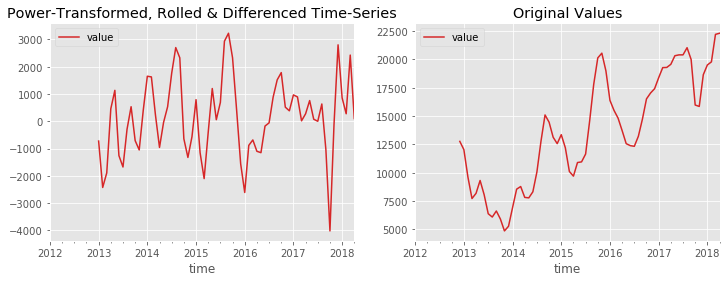

In [79]:
two_three_four_rolled_detrended_diff = two_three_four_rolled_detrended - two_three_four_rolled_detrended.shift()

ax1 = plt.subplot(121)
two_three_four_rolled_detrended_diff.plot(figsize=(8,4), color="tab:red", title="Power-Transformed, Rolled & Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
two_three_four_rolled_detrended.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

In [80]:
two_three_four = two_three_four_rolled_detrended_diff

### Retesting with the Dicky-Fuller Test

In [81]:
dftest = adfuller(two_three_four.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -4.765322510374742
2. P-Value :  6.333129997655005e-05
3. Num Of Lags :  6
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 57
5. Critical Values :
	 1% :  -3.5506699942762414
	 5% :  -2.913766394626147
	 10% :  -2.5946240473991997


### Parameter Selection

In [82]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [83]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_three_four, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [84]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 0, 1)
pdqs    (1, 1, 1, 12)
aic           860.924
Name: 15, dtype: object

### Fitting the Time Series Model - ARIMA

In [85]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_three_four, 
                                        order=(0, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9985      1.390     -0.719      0.472      -3.722       1.725
ma.S.L12      28.6437    135.349      0.212      0.832    -236.635     293.923
sigma2      4522.8250   4.16e+04      0.109      0.913    -7.7e+04    8.61e+04


### Plot Diagnostics

1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

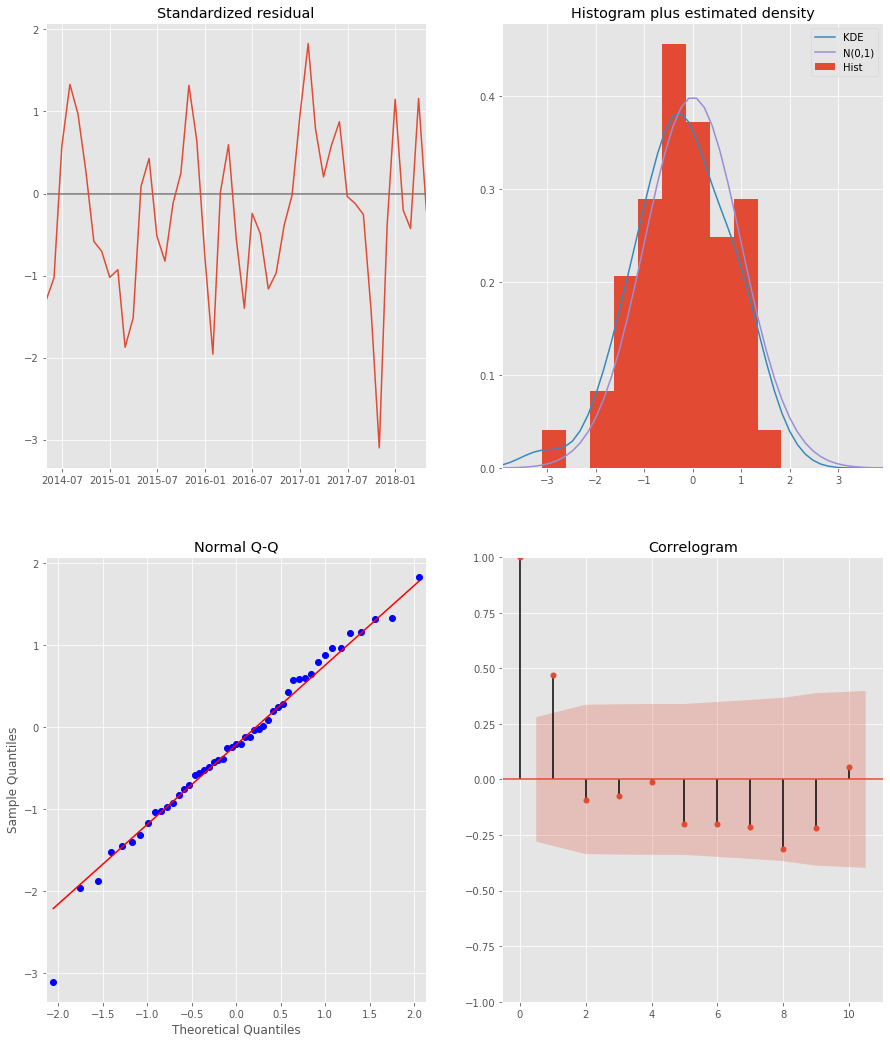

In [86]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [87]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

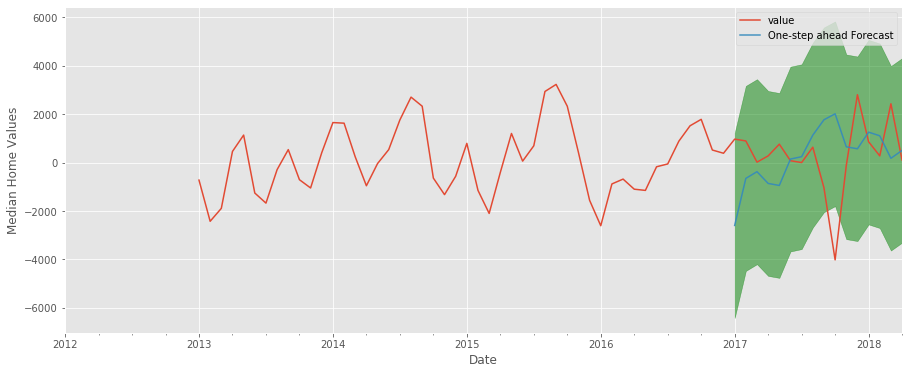

In [88]:

rcParams['figure.figsize'] = 15, 6

ax = two_three_four['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [89]:
val_forecasted = pred.predicted_mean
val_truth = two_three_four.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4726532.5


### Model Validation - Dynamic Forecasting

In [90]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

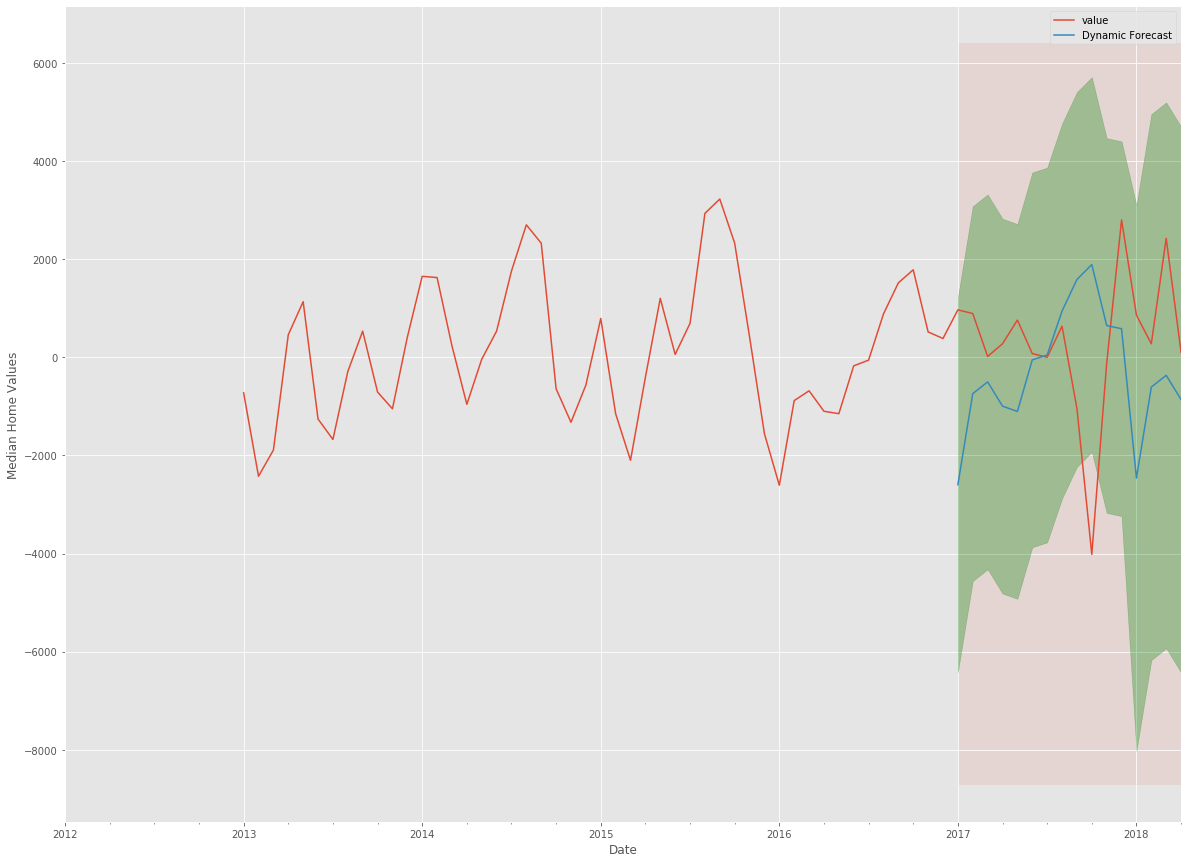

In [91]:
ax = two_three_four['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [92]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_three_four.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 5541933.98


### Visualizing Confidence Interval

In [93]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

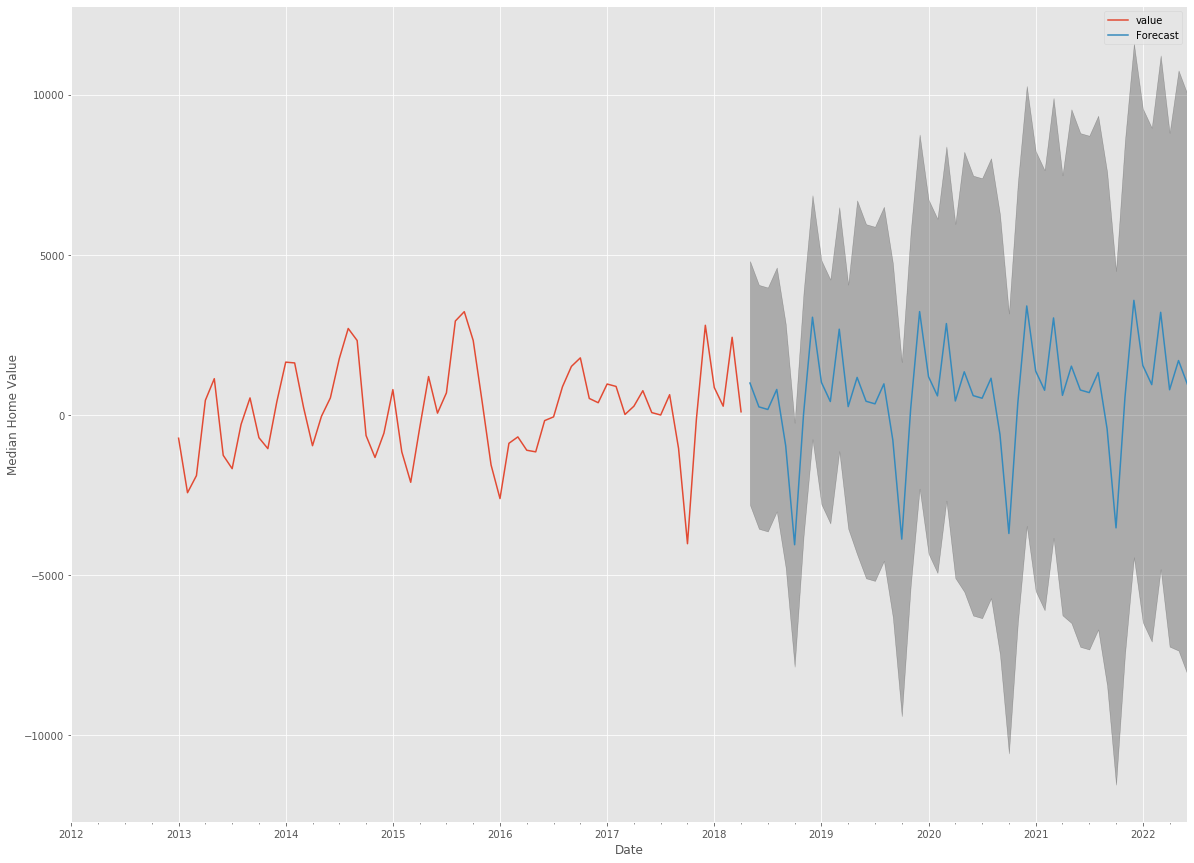

In [94]:
ax = two_three_four.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11234 Conclusion: 

### 11215

In [95]:
two_one_five = kings_grouped.loc[11215]

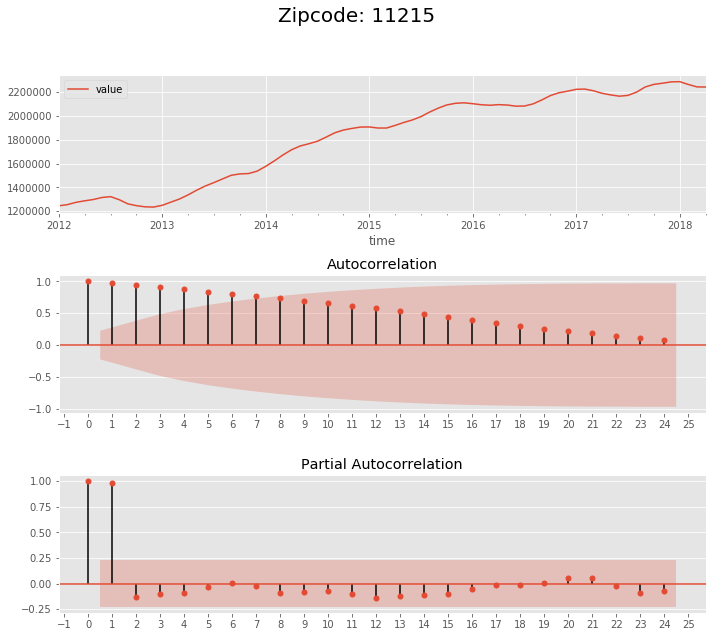

In [96]:
plot_acf_pacf(two_one_five, zipcode = '11215')
plt.show()

### Decompose Time Series

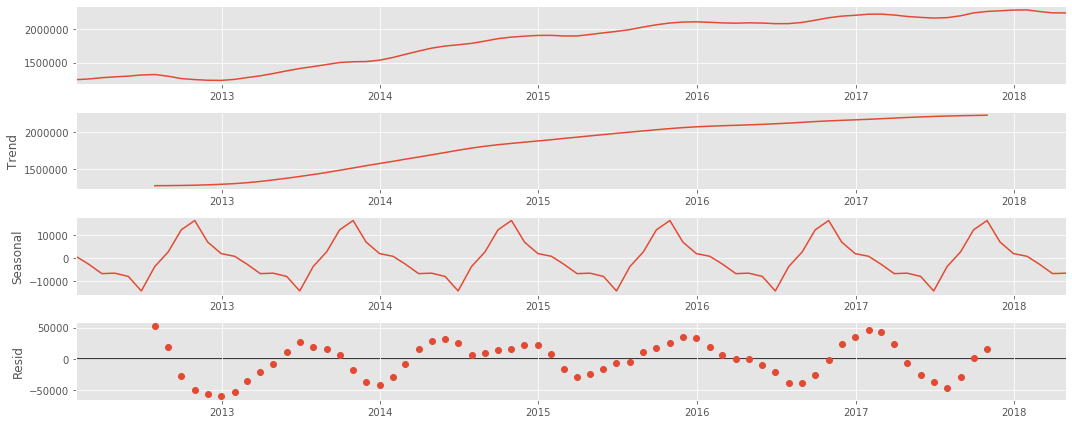

In [97]:
decompose_result = seasonal_decompose(two_one_five, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

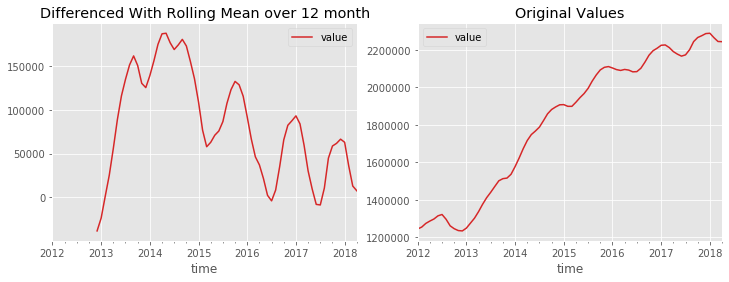

In [100]:
rolling_mean = two_one_five.rolling(window = 12).mean()
two_one_five_rolled_detrended = two_one_five - rolling_mean

ax1 = plt.subplot(121)
two_one_five_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_one_five.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [102]:
dftest = adfuller(two_one_five_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.375914598360866
2. P-Value :  0.5937669571321587
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 54
5. Critical Values :
	 1% :  -3.55770911573439
	 5% :  -2.9167703434435808
	 10% :  -2.59622219478738


### Using Differencing with Mean Rolled Time Series for Seasonality

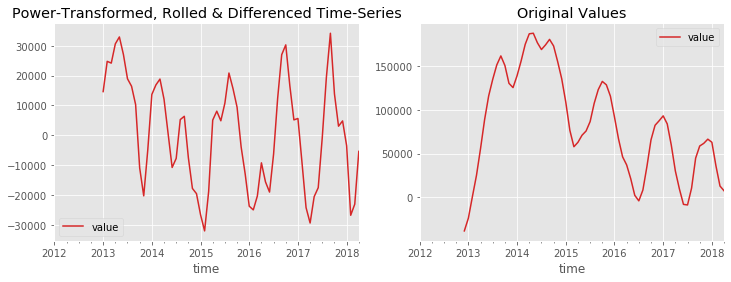

In [105]:
two_one_five_rolled_detrended_diff = two_one_five_rolled_detrended - two_one_five_rolled_detrended.shift()

ax1 = plt.subplot(121)
two_one_five_rolled_detrended_diff.plot(figsize=(8,4), color="tab:red", title="Power-Transformed, Rolled & Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
two_one_five_rolled_detrended.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

In [106]:
two_one_five = two_one_five_rolled_detrended_diff

### Retesting with the Dicky-Fuller Test

Technically does not have stationarity.

In [107]:
dftest = adfuller(two_one_five.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -4.297355862530089
2. P-Value :  0.00044891911778115515
3. Num Of Lags :  6
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 57
5. Critical Values :
	 1% :  -3.5506699942762414
	 5% :  -2.913766394626147
	 10% :  -2.5946240473991997


### Parameter Selection

In [108]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [109]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_one_five, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [110]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1041.72
Name: 27, dtype: object

### Fitting the Time Series Model - ARIMA

COMMENTS ON THE P VALUES - LOW P VAL = GOOD 

In [111]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_one_five, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2012      0.403      0.500      0.617      -0.588       0.991
ma.L1          0.3997      0.400      1.001      0.317      -0.383       1.183
ma.S.L12      -0.7703      0.179     -4.294      0.000      -1.122      -0.419
sigma2      1.147e+08   2.73e-10   4.21e+17      0.000    1.15e+08    1.15e+08


### Plot Diagnostics

COMMENTS ON PLOT: 
1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

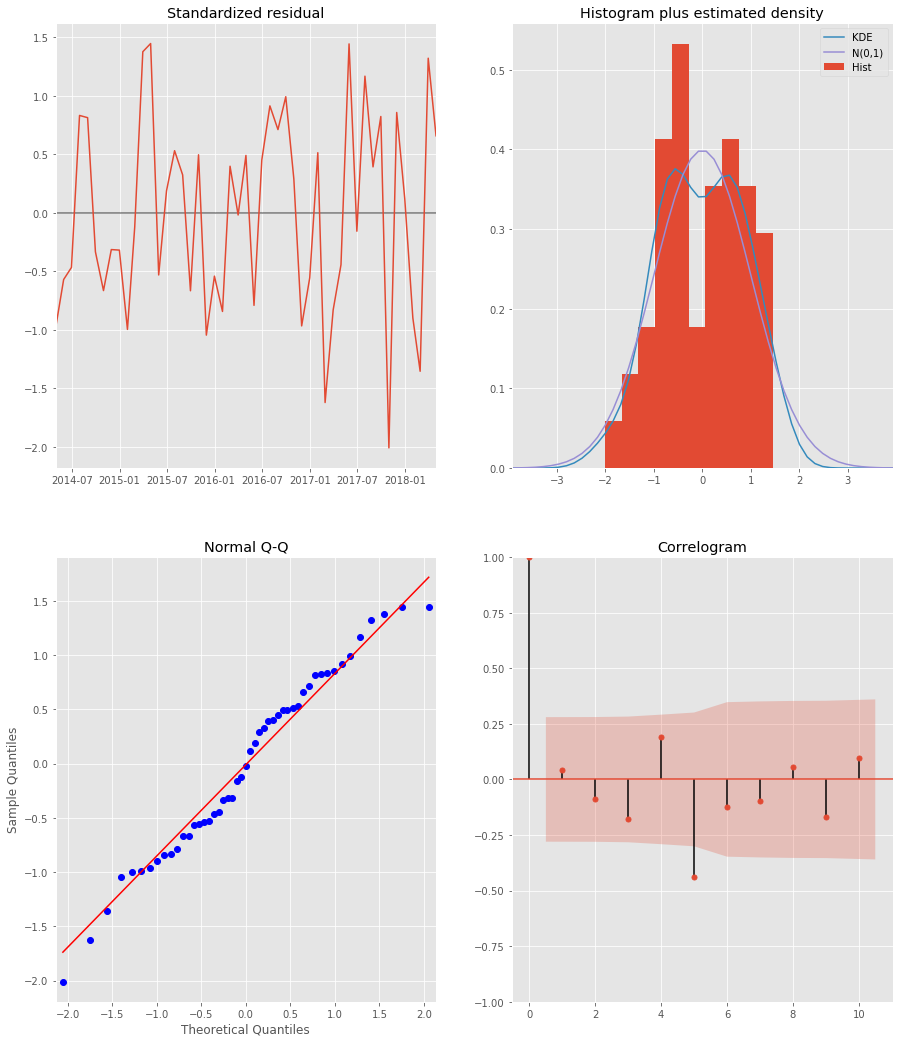

In [112]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [113]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

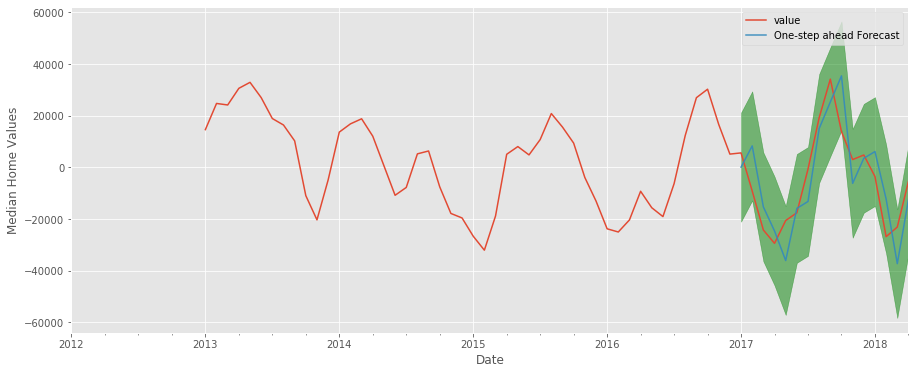

In [114]:

rcParams['figure.figsize'] = 15, 6

ax = two_one_five['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [115]:
val_forecasted = pred.predicted_mean
val_truth = two_one_five.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 127838001.66


### Model Validation - Dynamic Forecasting

In [116]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

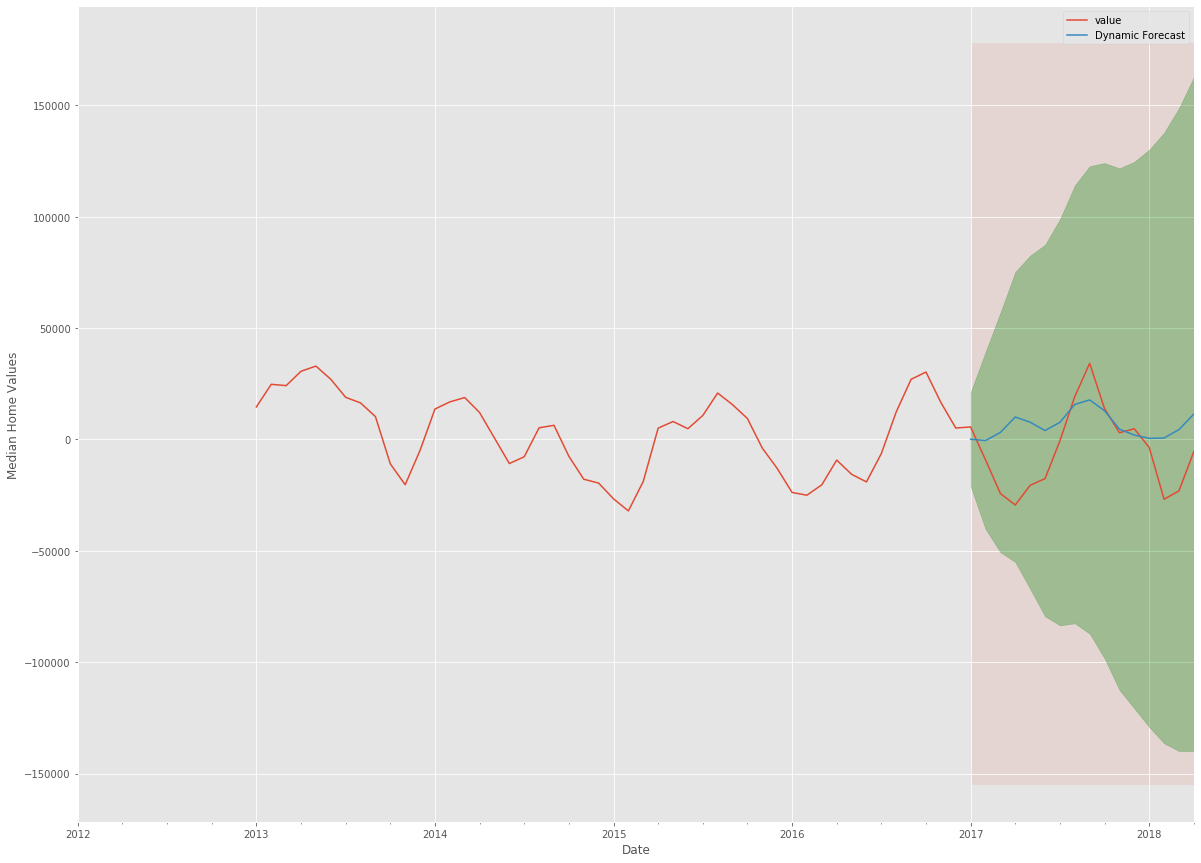

In [117]:
ax = two_one_five['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [118]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_one_five.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 366387795.83


### Visualizing Confidence Interval

In [119]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

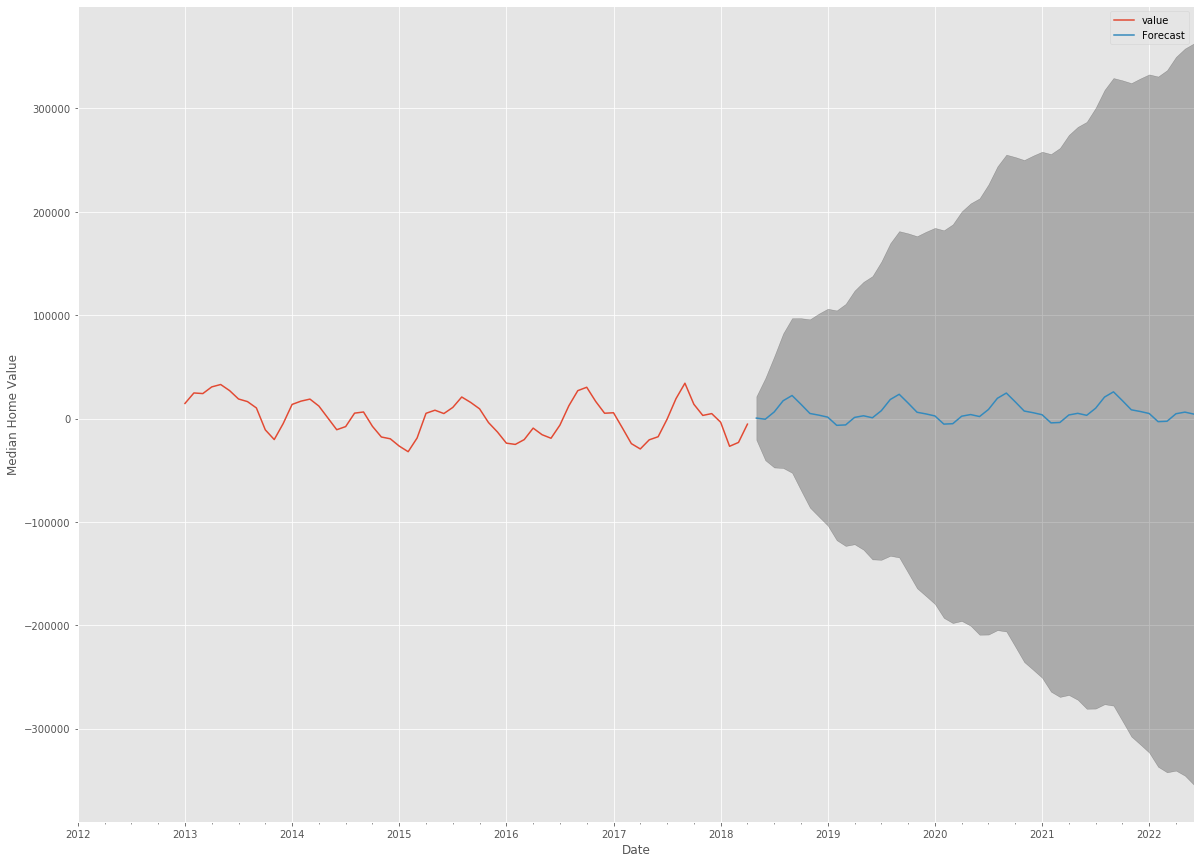

In [120]:
ax = two_one_five.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11215 Conclusion: 

### 11211

In [121]:
two_one_one = kings_grouped.loc[11211]

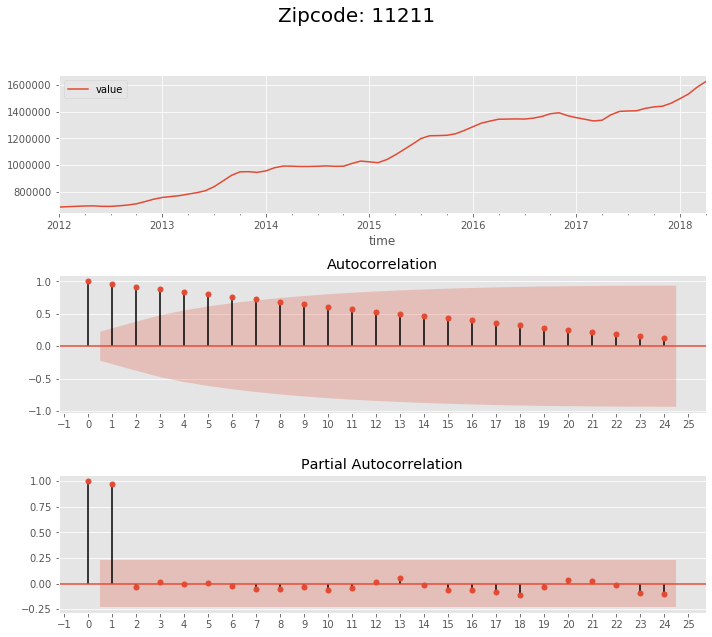

In [122]:
plot_acf_pacf(two_one_one, zipcode = '11211')
plt.show()

### Decompose Time Series

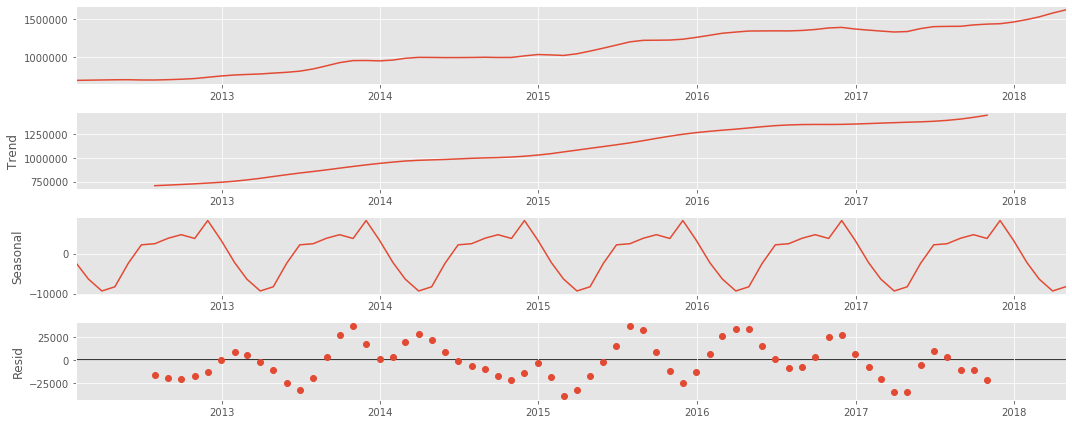

In [123]:
decompose_result = seasonal_decompose(two_one_one, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

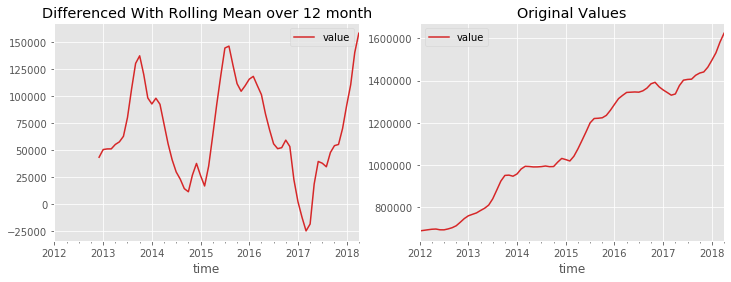

In [125]:
rolling_mean = two_one_one.rolling(window = 12).mean()
two_one_one_rolled_detrended = two_one_one - rolling_mean

ax1 = plt.subplot(121)
two_one_one_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_one_one.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [126]:
dftest = adfuller(two_one_one_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.161335124224558
2. P-Value :  0.022334705084455935
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 54
5. Critical Values :
	 1% :  -3.55770911573439
	 5% :  -2.9167703434435808
	 10% :  -2.59622219478738


### Using Differencing with Mean Rolled Time Series for Seasonality

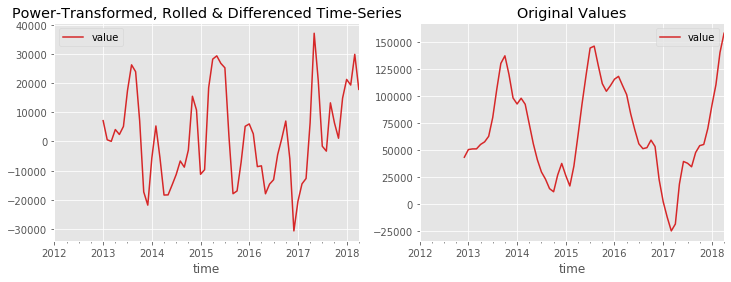

In [127]:
two_one_one_rolled_detrended_diff = two_one_one_rolled_detrended - two_one_one_rolled_detrended.shift()

ax1 = plt.subplot(121)
two_one_one_rolled_detrended_diff.plot(figsize=(8,4), color="tab:red", title="Power-Transformed, Rolled & Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
two_one_one_rolled_detrended.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

In [128]:
two_one_one = two_one_one_rolled_detrended_diff

### Retesting with the Dicky-Fuller Test

Technically does not have stationarity.

In [129]:
dftest = adfuller(two_one_one.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.172902532633665
2. P-Value :  0.021607748796036476
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 54
5. Critical Values :
	 1% :  -3.55770911573439
	 5% :  -2.9167703434435808
	 10% :  -2.59622219478738


### Parameter Selection

In [130]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [131]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_one_one, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [132]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 1, 1)
pdqs    (1, 1, 1, 12)
aic           1078.91
Name: 31, dtype: object

### Fitting the Time Series Model - ARIMA

In [134]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_one_one, 
                                        order=(0, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5770      0.568      1.016      0.310      -0.536       1.690
ar.S.L12      -0.5268      0.740     -0.712      0.477      -1.978       0.924
ma.S.L12      -1.0429      0.854     -1.221      0.222      -2.717       0.631
sigma2      3.773e+08   1.38e-09   2.73e+17      0.000    3.77e+08    3.77e+08


### Plot Diagnostics


1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

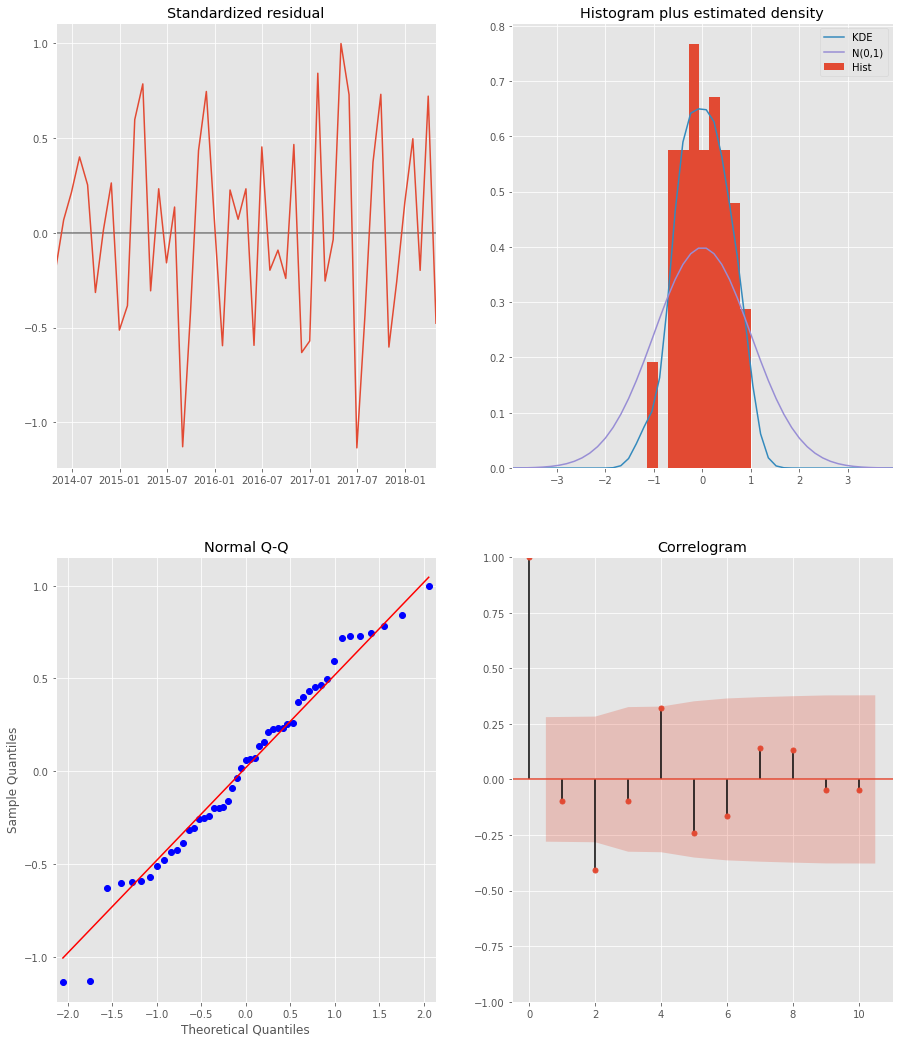

In [135]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [136]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

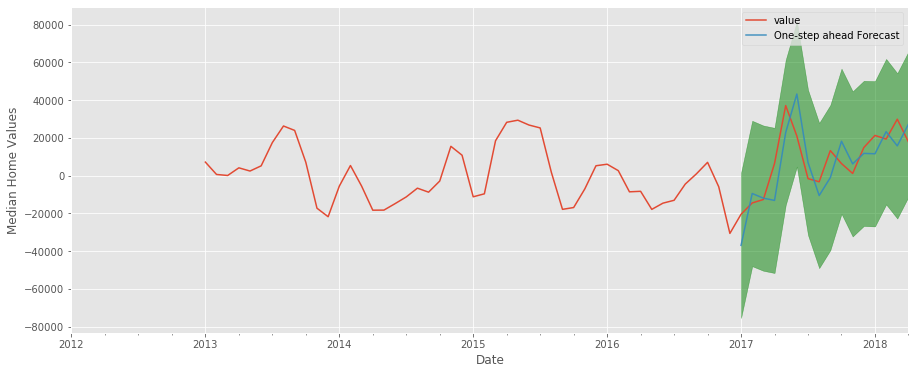

In [137]:

rcParams['figure.figsize'] = 15, 6

ax = two_one_one['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [138]:
val_forecasted = pred.predicted_mean
val_truth = two_one_one.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 142663859.81


### Model Validation - Dynamic Forecasting

In [139]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

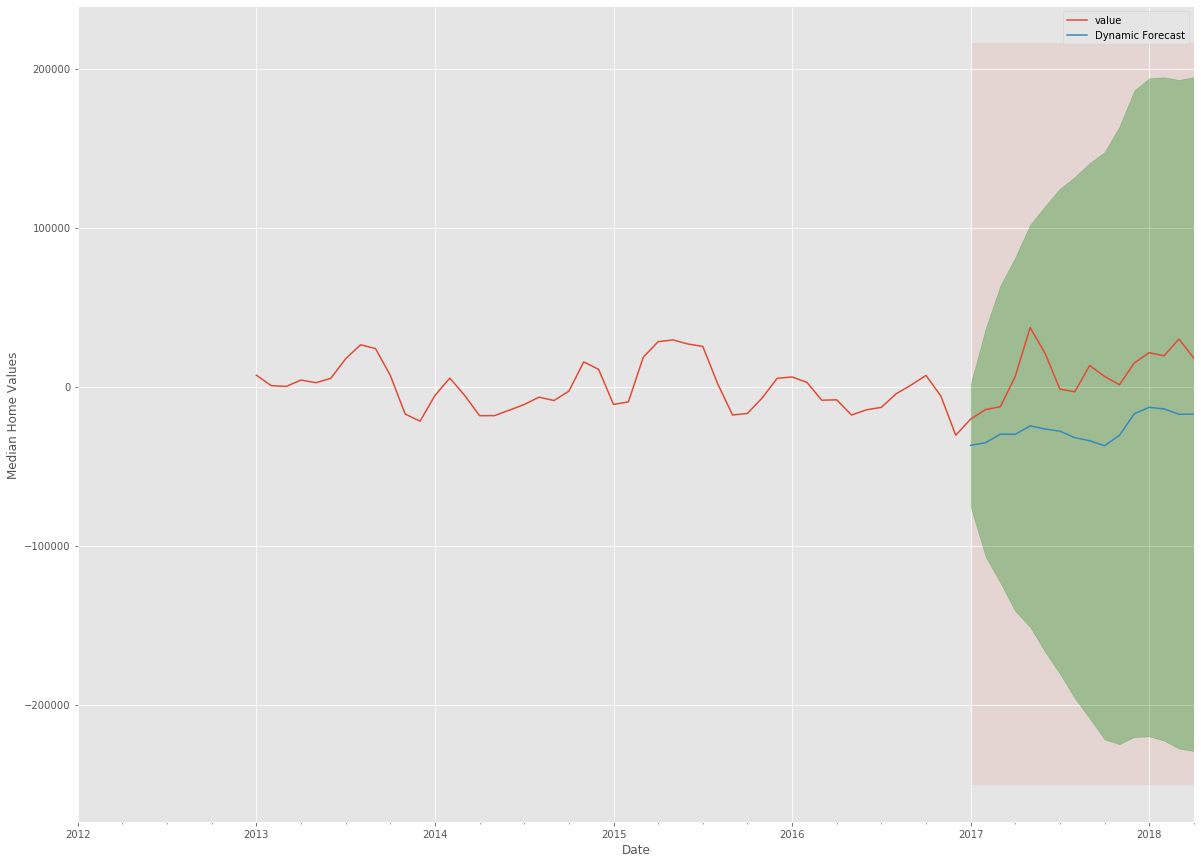

In [140]:
ax = two_one_one['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [141]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_one_one.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1368378757.8


### Visualizing Confidence Interval

In [142]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

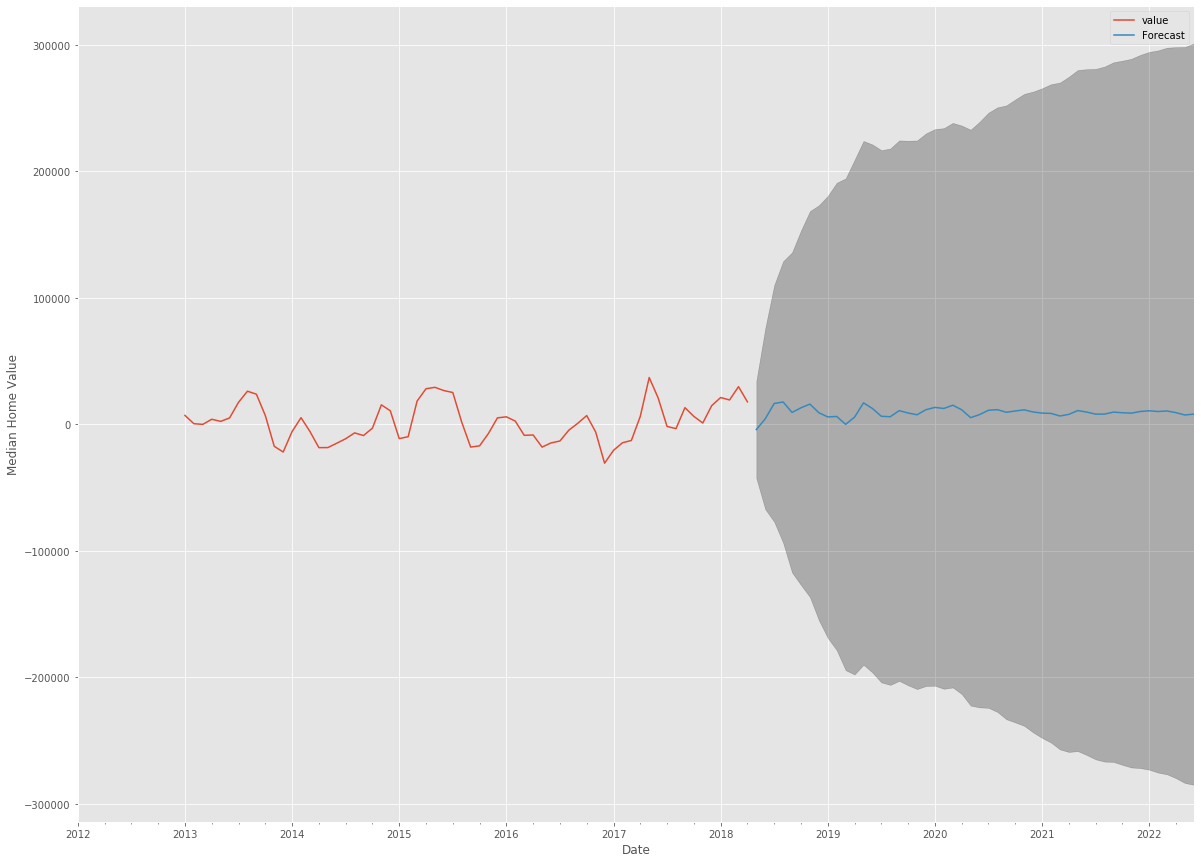

In [143]:
ax = two_one_one.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11211 Conclusion: 

### 11238

In [145]:
two_three_eight = kings_grouped.loc[11238]

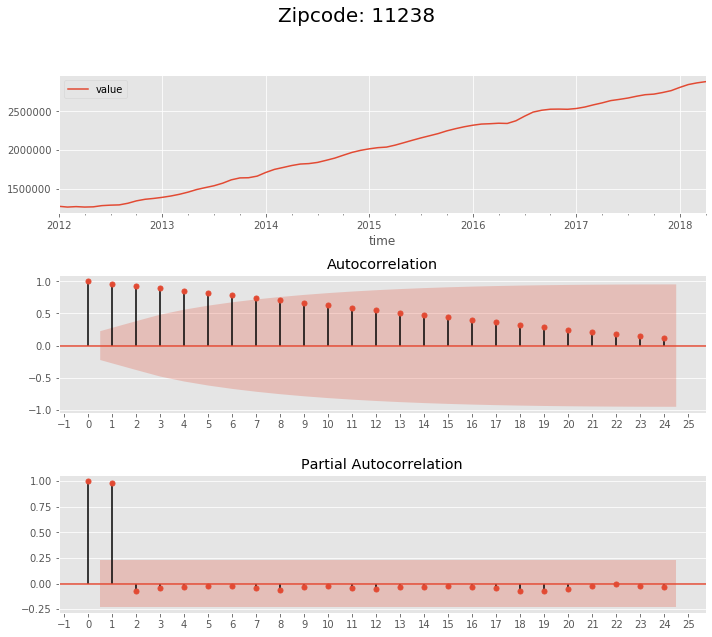

In [146]:
plot_acf_pacf(two_three_eight, zipcode = '11238')
plt.show()

### Decompose Time Series

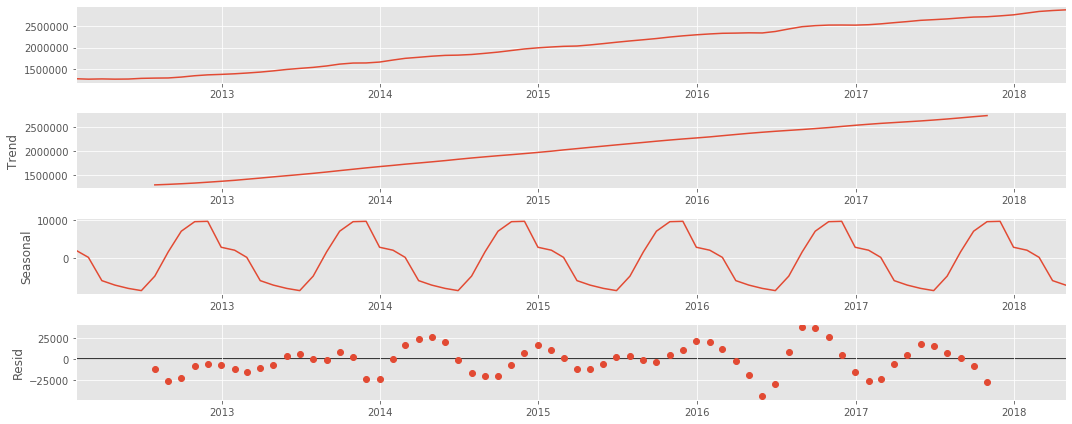

In [147]:
decompose_result = seasonal_decompose(two_three_eight, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

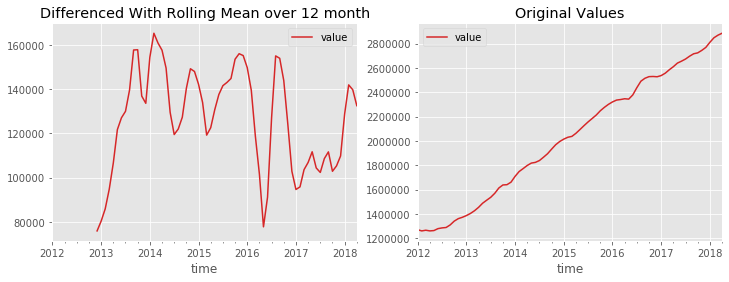

In [149]:
rolling_mean = two_three_eight.rolling(window = 12).mean()
two_three_eight_rolled_detrended = two_three_eight - rolling_mean

ax1 = plt.subplot(121)
two_three_eight_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_three_eight.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [150]:
dftest = adfuller(two_three_eight_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.3061977896554504
2. P-Value :  0.014603695989147812
3. Num Of Lags :  2
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 62
5. Critical Values :
	 1% :  -3.540522678829176
	 5% :  -2.9094272025108254
	 10% :  -2.5923136524453696


In [154]:
two_three_eight = two_three_eight_rolled_detrended.dropna()

### Parameter Selection

In [155]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [156]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_three_eight, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [157]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic            829.42
Name: 59, dtype: object

### Fitting the Time Series Model - ARIMA

In [158]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_three_eight, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3796      0.323      1.174      0.240      -0.254       1.013
ma.L1          0.4158      0.349      1.191      0.234      -0.268       1.100
ma.S.L12      -0.4963      0.162     -3.062      0.002      -0.814      -0.179
sigma2      2.055e+08   4.71e-10   4.36e+17      0.000    2.06e+08    2.06e+08


### Plot Diagnostics


1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

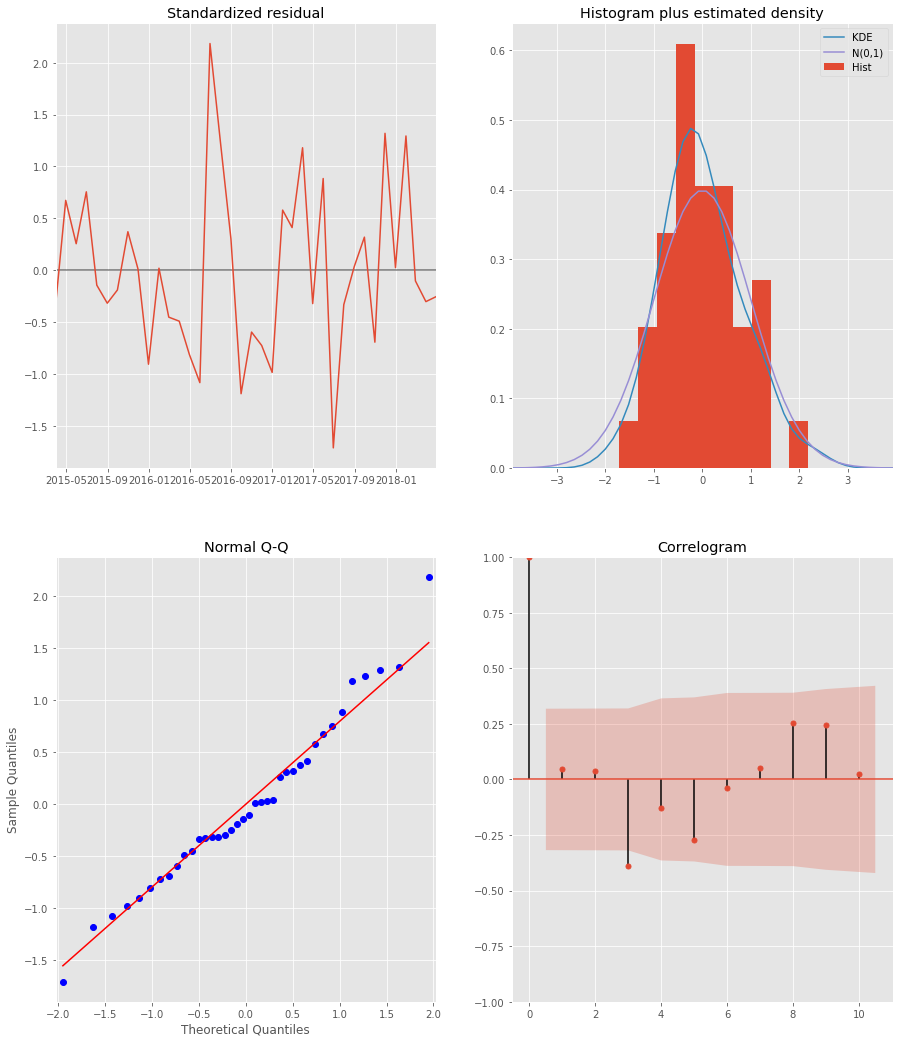

In [159]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [160]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

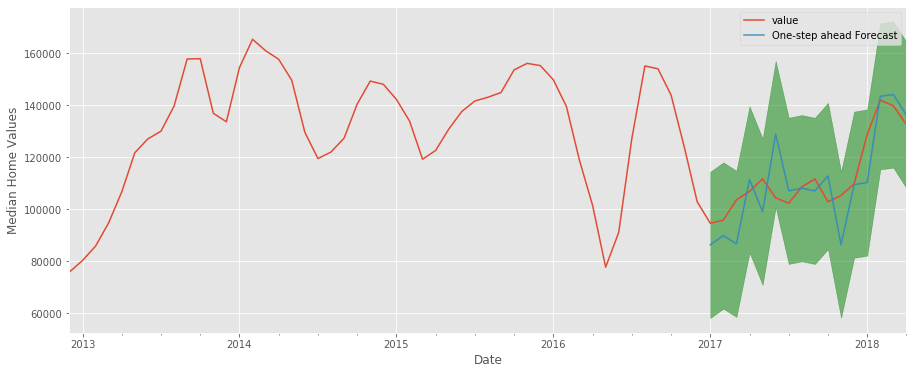

In [161]:

rcParams['figure.figsize'] = 15, 6

ax = two_three_eight['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [162]:
val_forecasted = pred.predicted_mean
val_truth = two_three_eight.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 128204796.58


### Model Validation - Dynamic Forecasting

In [163]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

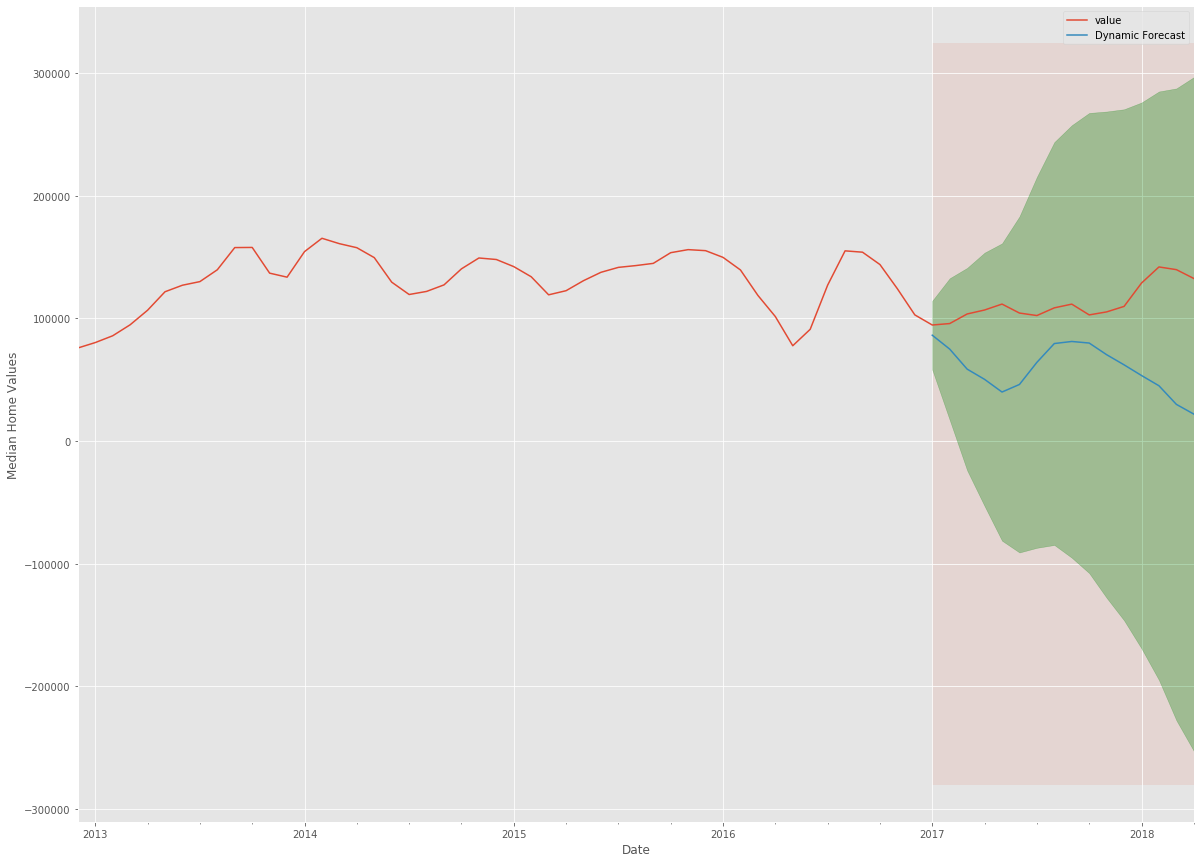

In [164]:
ax = two_three_eight['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [165]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_three_eight.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 3803566958.59


### Visualizing Confidence Interval

In [166]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

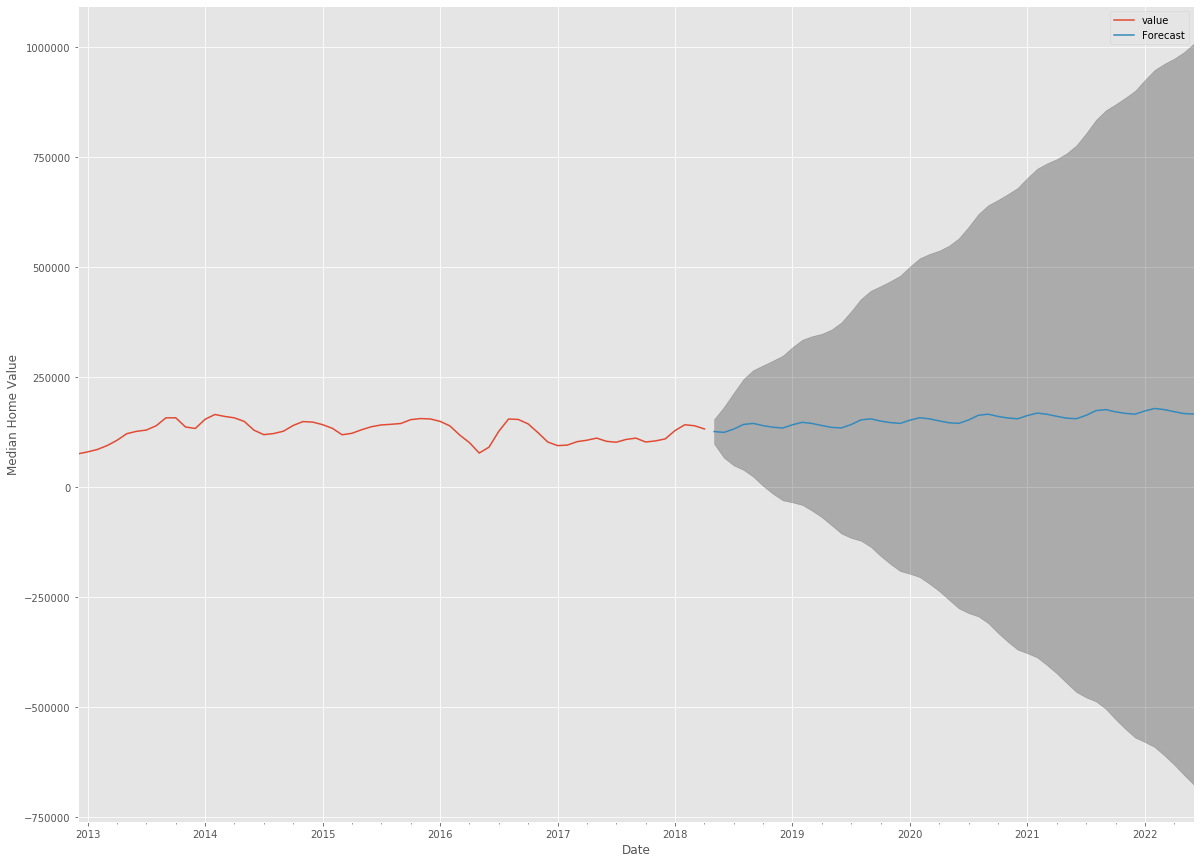

In [167]:
ax = two_three_eight.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11238 Conclusion: 